Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

Loading The Dataset

In [2]:
df = pd.read_csv('../data/processed/telco_data_binned.csv')

In [3]:
df.head()

,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Binned
0,France,Female,42.0,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,42.0,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,37.0,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0,Excellent


Preparing Pipeline

In [13]:
numerical_features = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
nominal_features = ['Gender', 'Geography'] 
ordinal_features = ['CreditScore_Binned']
remaining_features = ['HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Exited']


numerical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)


nominal_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder())
    ]
)


ordinal_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OrdinalEncoder())
    ]
)


preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)     
    ],
    remainder = 'drop'
)

nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend(f"{feature}_{val}" for val in unique_values)
    
df_cpy = df.copy()
df_transformed = pd.DataFrame(
    preprocessor.fit_transform(df_cpy),
    columns = numerical_features + nominal_feature_names + ordinal_features
)

df_remainder = df_cpy[remaining_features]
df_final = pd.concat([df_transformed, df_remainder], axis=1)

df_final.head()
    

,Age,Tenure,Balance,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Spain,Geography_Germany,CreditScore_Binned,HasCrCard,IsActiveMember,NumOfProducts,Exited
0,0.313916,-1.041760,-1.225848,0.021886,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1,1
1,0.215897,-1.387538,0.117350,0.216534,1.0,0.0,0.0,0.0,1.0,1.0,0,1,1,0
2,0.313916,1.032908,1.333053,0.240687,1.0,0.0,1.0,0.0,0.0,3.0,1,0,3,1
3,-0.176180,-1.387538,-1.225848,-0.108918,1.0,0.0,1.0,0.0,0.0,2.0,0,0,2,0
4,0.411935,-1.041760,0.785728,-0.365276,1.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0


Saving The Final CSV

In [5]:
df_final.to_csv('../data/processed/telco_data_prepared.csv', index=False)

In [6]:
X = df_final.drop('Exited', axis=1)
Y = df_final['Exited']

In [7]:
Y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [9]:
X_train.shape, X_test.shape

((8000, 13), (2000, 13))

In [10]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'counts')

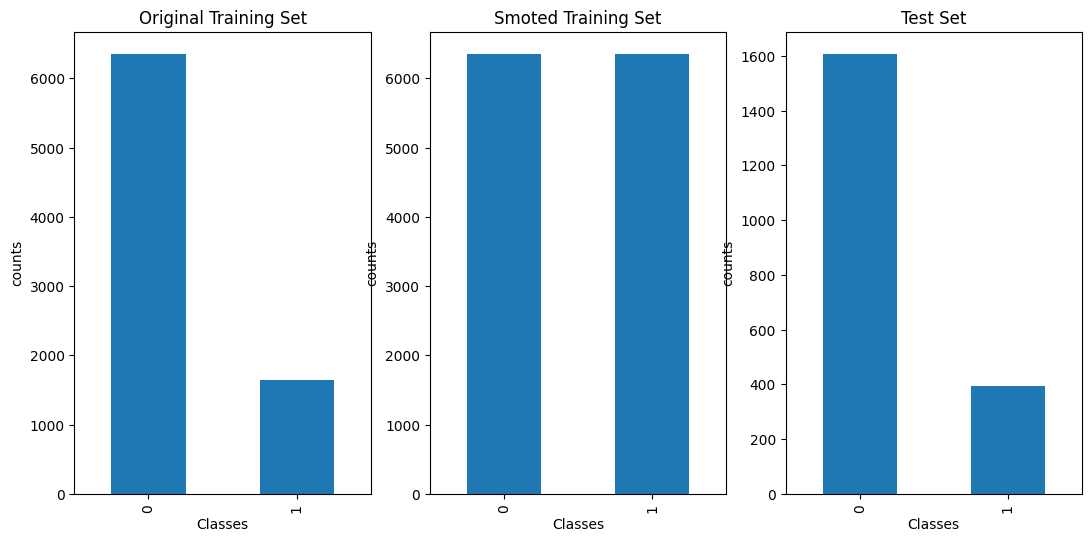

In [11]:
plt.figure(figsize=(13, 6))

# Original Train Set
plt.subplot(131)
Y_train.value_counts().plot(kind='bar', title='Original Training Set')
plt.xlabel('Classes')
plt.ylabel('counts')

# Smoted Training Set
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar', title='Smoted Training Set')
plt.xlabel('Classes')
plt.ylabel('counts')

# Original Test Set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar', title='Test Set')
plt.xlabel('Classes')
plt.ylabel('counts')


In [ ]:
np.savez('../artifacts/X_train.npz', X_train_resampled)
np.savez('../artifacts/Y_train.npz', Y_train_resampled)
np.savez('../artifacts/X_test.npz', X_test)
np.savez('../artifacts/Y_test.npz', Y_test)